In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from material_models import GOH_fullyinc
from misc import preprocessing, normalization, predict
import tensorflow as tf
import pickle
fsize=5
pltparams = {'legend.fontsize': 'large',
          'figure.figsize': (fsize*5,fsize),
          'font.size'     : 3*fsize,
          'axes.labelsize': 4*fsize,
          'axes.titlesize': 4*fsize,
          'xtick.labelsize': 3.5*fsize,
          'ytick.labelsize': 3.5*fsize,
          'lines.linewidth': 5,
          'lines.markersize': 10,
          'lines.markeredgewidth': 2,
          'axes.titlepad': 25,
          "mathtext.fontset": 'dejavuserif',
          'axes.labelpad': 5}
plt.rcParams.update(pltparams)
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.inferno(np.linspace(0.1, 0.7, 2)))
import pandas as pd

In [2]:
samples = ['S111S1', 'S111S4', 'S112S2', 'S112S3', 'S112S4', 'S113S3', 'S113S4', 'S143S1', 'S143S2', 'S144S3', 'S144S4']
limits = [[0, 183, 2*183, 3*183], [0, 184, 367, 3*183], [0, 184, 367, 3*183], [0, 183, 366, 3*183], [0, 184, 367, 3*183], [0, 183, 366, 3*183], 
            [0, 183, 366, 3*183], [0, 62, 121, 3*183], [0, 62, 123, 3*183], [0, 62, 123, 3*183], [0, 62, 123, 3*183]]
# loss_tbl = pd.read_csv('savednet/loss_per_angle.csv')
# l2_tbl = pd.read_csv('savednet/l2_per_angle.csv')
# l3_tbl = pd.read_csv('savednet/l3_per_angle.csv')
best_angles = [30, 10, 15, 5, 10, 10, 20, 25, 15, 15, 40]

In [3]:
def plot_murine(impose_convexity):
    fig = plt.figure(figsize=(20,60))
    gs1 = fig.add_gridspec(11,2, wspace=0.15, hspace=0.25, left = 0.05, right = 0.4) #nrows, ncols
    gs2 = fig.add_gridspec(11,2, wspace=0.3, hspace=0.25, left = 0.48, right = 0.84)

    for a, (sample, lim, theta) in enumerate(zip(samples, limits, best_angles)):
        # loss_per_theta = loss_tbl[sample]
        # theta = loss_per_theta.idxmin()*5 #best theta
        data = sample+'_xyb'
        model = sample+'_xys_theta_'+str(theta)
        ndata, I1, I2, I4a, I4s, Psi_gt, X, Y, sigma_gt, F, C, C_inv  = preprocessing(data, theta)
        sigma_pr, _, _, _, _, _ = predict(model, data, impose_convexity, theta)
        
        error = np.zeros(sigma_gt.shape[0])
        for i in range(sigma_gt.shape[0]):
            for j in range(3):
                for k in range(3):
                    error[i]+= (sigma_gt[i,k,j] - sigma_pr[i,k,j])**2
            error[i] = np.sqrt(error[i])
        error = error*1000 #MPa -> kPa
        offx_error = np.mean(error[:lim[1]])
        offy_error = np.mean(error[lim[1]:lim[2]])
        equi_error = np.mean(error[lim[2]:lim[3]])

        ax1 = fig.add_subplot(gs1[a,0])
        ax2 = fig.add_subplot(gs1[a,1])
        ax3 = fig.add_subplot(gs2[a,0])

        axes = [ax1, ax2, ax3]
        errs = [offx_error, offy_error, equi_error]
        for i, (ax, err) in enumerate(zip(axes, errs)):
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set(xlabel = '$\\lambda_x$')

            i1 = lim[i]
            i2 = lim[i+1]
            ax.plot(X[i1:i2,0], sigma_gt[i1:i2,0,0]*1000,'.', alpha=0.2, label='$\\sigma_{xx}$ (Exp.)')
            ax.plot(X[i1:i2,0], sigma_gt[i1:i2,1,1]*1000,'.', alpha=0.2, label='$\\sigma_{yy}$ (Exp.)')

            ax.plot(X[i1:i2,0], sigma_pr[i1:i2,0,0]*1000, label='$\\sigma_{xx}$ (DNN)')
            ax.plot(X[i1:i2,0], sigma_pr[i1:i2,1,1]*1000, label='$\\sigma_{yy}$ (DNN)')
            if a == i == 0:
                errtext = '$NN_E$= %.2f [kPa]' %err
                ax.legend(loc='center left')
            else:
                errtext = '%.2f' %err
            ax.text(0.05,0.95, errtext, transform=ax.transAxes, va='top')
        if a == 0:
            ax1.text(1.05, 1.05, 'Training Dataset', transform=ax1.transAxes, ha='center')
            ax3.text(0.5, 1.05, 'Validation Dataset', transform=ax3.transAxes, ha='center')
        ax1.set(ylabel = '$\\sigma$ [kPa]')
        ax3.set(ylabel = '$\\sigma$ [kPa]')
    return fig

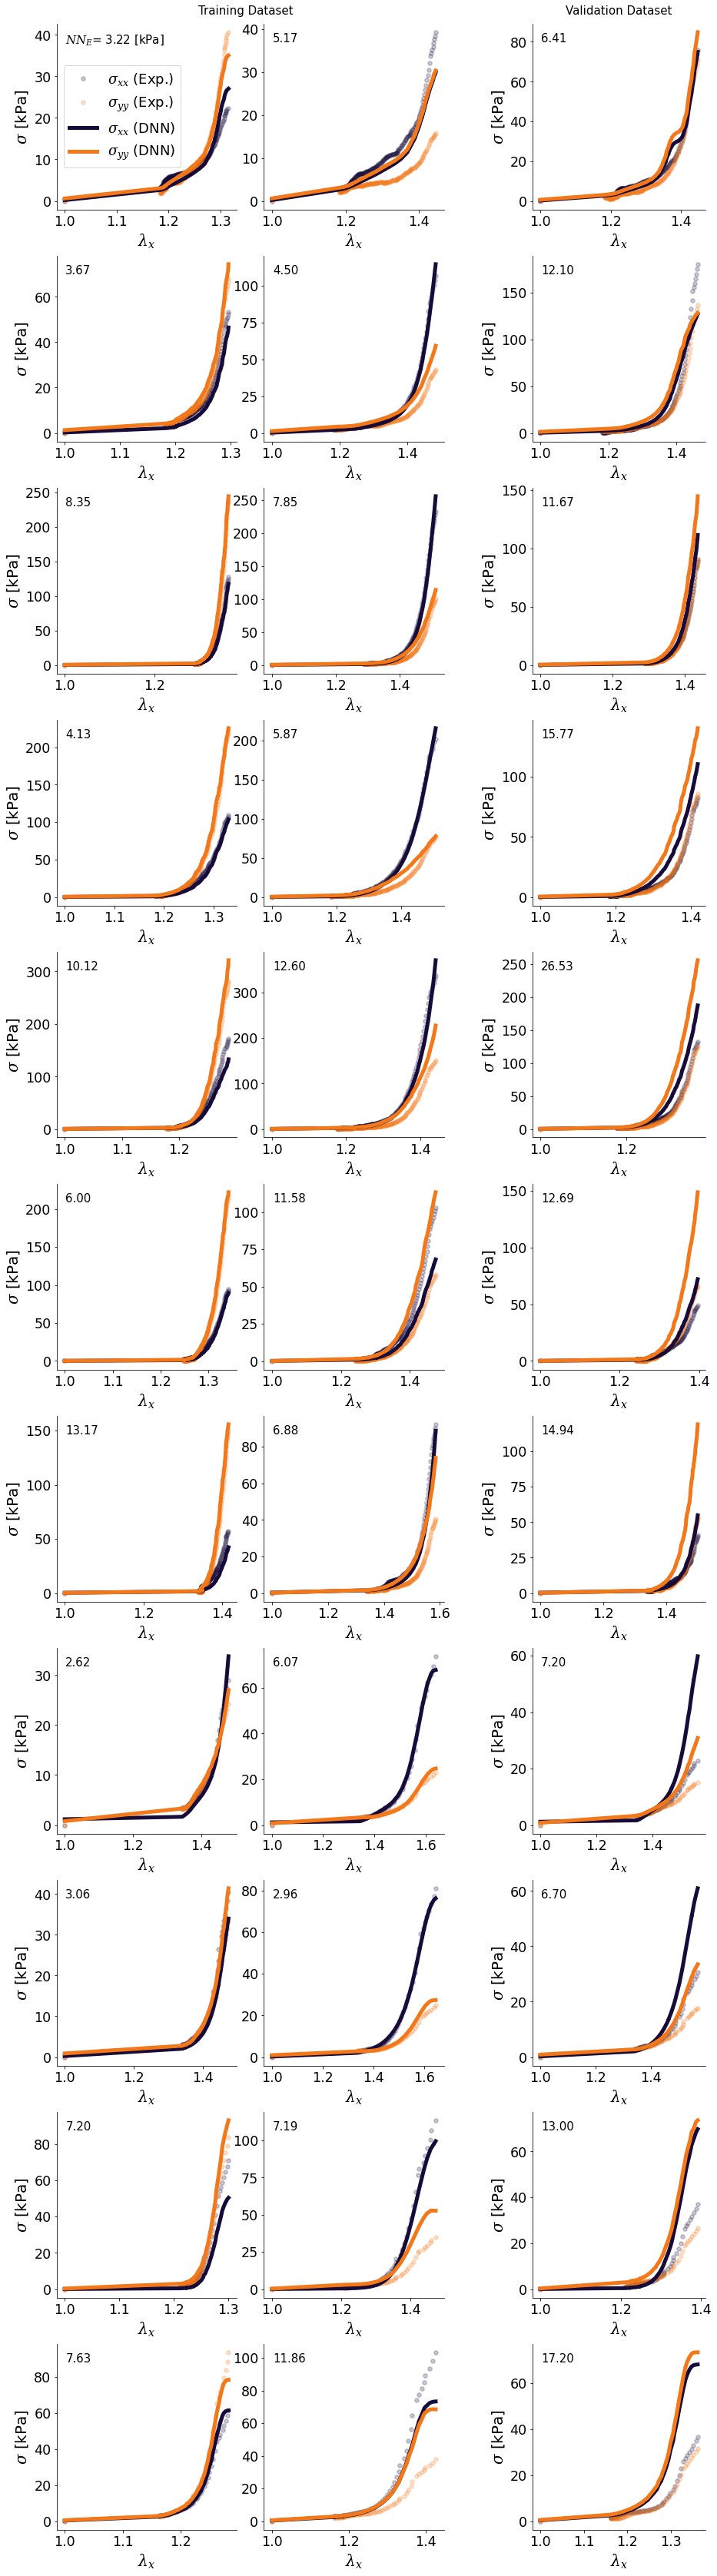

In [5]:
fig = plot_murine(True)
fig.savefig('figs/fig_murine_summary_convex.jpg', dpi=400, bbox_inches='tight')
fig.savefig('figs/Supplement 2.jpg', dpi=400, bbox_inches='tight')